In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns
from tqdm import tqdm
%matplotlib inline

In [2]:
actions = {"hit" : 1, "stick": 0}
rewards = {"win" : 1, "lose" : -1, "draw": 0}

In [3]:
class Agent:
    
    def __init__(self, policy_eval = False):
        self.policy_eval = policy_eval # Boolean to identify off policy methods
        self.reset_history()
        
    def reset_history(self):
        self.cards_value = 0 # stores sum of card values with agent
        self.usable_ace = False # stores presence of usable ace amongst cards
        self.num_aces = 0 # stores number of aces (usable and not)
        self.card_history = [] # cards with player (redundant)
        
    def set_policy_eval(self):
        self.policy_eval = True 
        
    # load a pre-specified state
    def set_full_state(self,dealer_card1,usable_ace,player_sum):
        self.dealer_card1 = dealer_card1
        self.usable_ace = usable_ace
        #self.player_sum = player_sum
        self.cards_value = player_sum
        self.num_aces = int(usable_ace)
        
    # add a custom policy for agent
    def set_custom_policy(self,policy):
        self.policy = policy
        
    # perform an action in the current state
    def perform_action(self):
        if self.policy_eval:
            return self.policy[int(self.usable_ace), self.dealer_card1 - 1, self.cards_value-12]
        return self.policy[self.cards_value]
    
    # random action selection probability
    def behaviour_random_policy_action(self):
        return np.random.randint(2)
        
    def get_sum(self):
        return self.cards_value
    
    
    # Draws card at random and returns its value
    # All face cards have a value of 10
    def __draw_card(self):
        card = random.randint(1,13)
        card_value = min(card,10)
        return card_value
        
        
    # Pick a new card
    def pick_card(self):
        new_card = self.__draw_card() # draws a card
        if new_card == 1: # checks if it is an ace
            self.cards_value += 11
            # trying using it as a usable ace
            if self.cards_value > 21:
                self.cards_value -= 10
            else:
                self.num_aces += 1
        else:
            self.cards_value += new_card
                
        # if we had a usable ace added at some point, but now are over 21, then make ace unusable
        while  self.cards_value > 21 :
            if self.num_aces > 0:
                self.cards_value -= 10
                self.num_aces -= 1
            else:
                break
                                
        self.usable_ace = self.num_aces >= 1
            
        return (self.cards_value,self.usable_ace)
      
        

In [4]:
class BlackJack:
    
    def __init__(self):
        self.reset_episode_history()
        
    def reset_episode_history(self):
        self.episode_history = []
    
    def get_trgt_player_policy(self):
        policy = np.ones(22,dtype = "uint8")
        for i in range(20,22):
            policy[i] = actions["stick"]
        return policy
        
    def get_dealer_policy(self):
        policy = np.ones(22,dtype = "uint8")
        for i in range(17,22):
            policy[i] = actions["stick"]
        return policy
    
    # Generate a random start state
    def generate_start_state(self,player,dealer):
        player_sum, usable_ace = player.get_sum() ,False
    
        # Creating player initial state. Note that since policy of sum < 12 is trivial, 
        # we draw as many cards as required until sum >= 12
        while player_sum < 12:
            player_sum, usable_ace = player.pick_card()  

        dealer_card1, _ = dealer.pick_card() # Picking card of dealer A --> 10
        if dealer_card1 == 11: 
            dealer_card1 = 1 # Ace

        return player_sum, dealer_card1, usable_ace
        
    # Simulate episode
    def play_episode(self,state_0 = None,action_0 = None,policy = None,off_policy = False):
        
        player = Agent()
        player.set_custom_policy(self.get_trgt_player_policy())
        dealer = Agent()
        dealer.set_custom_policy(self.get_dealer_policy())
        
        start_state = state_0
        
        if state_0 is None: # On-policy first visit monte carlo prediction - Fig5.1
            start_state = self.generate_start_state(player,dealer)
        elif off_policy: # off policy
            player_sum,dealer_card1,usable_ace = state_0
            player.set_full_state(dealer_card1,usable_ace,player_sum)
        else: # Exploring starts 
            # Setting state and policy
            player_sum,dealer_card1,usable_ace = state_0
            player.set_custom_policy(policy)
            player.set_policy_eval()
            player.set_full_state(dealer_card1,usable_ace,player_sum)
            
        dealer_card2, _ = dealer.pick_card()
        self.reset_episode_history()
        
        prev_sum , dealer_card1, usable_ace = start_state
        
        # Player's draws
        while True:
            next_action = player.perform_action()
            if action_0 is not None: # Setting action for exploring starts
                next_action = action_0
                action_0 = None
                
            if off_policy: # Setting action using behaviour policy
                next_action = player.behaviour_random_policy_action()
    
            # Building episode history
            self.episode_history.append([(int(usable_ace), dealer_card1 - 1, prev_sum - 12),next_action]) 
            
            # Stop drawing when u decide to stick
            if next_action == actions["stick"]:
                break
            prev_sum, usable_ace = player.pick_card()
            
            # Lose if sum exceeds 21
            if prev_sum > 21:
                return self.episode_history , rewards["lose"]
            
        # Dealers's draws
        while True:
            next_action = dealer.perform_action()
            if next_action == actions["stick"]:
                break   
            prev_sum, _ = dealer.pick_card()
            if prev_sum > 21:
                return self.episode_history , rewards["win"]
            
        # Deciding result of episode
        if dealer.get_sum() == player.get_sum():
            return self.episode_history , rewards["draw"]
        elif dealer.get_sum() > player.get_sum():
            return self.episode_history , rewards["lose"]
        else :
            return self.episode_history , rewards["win"]         
    

In [5]:
def fig5_3():
    true_val = -0.27726
    start_sum, dealer_card, usable_ace = (13,2,True)
    episodes = 10000
    runs = 100
    
    # initailizing errors for different importance sampling methods
    error_ordinary_sampling = np.zeros(episodes)
    error_weighted_sampling = np.zeros(episodes)
    
    game = BlackJack()
    
    trgt_policy = np.ones(22)
    trgt_policy[20:] -= 1.
    
    # Iterating over runs
    for r in tqdm(range(1,runs+1)):  
        
        # Initializing weighted returns and ratios
        ratios = np.zeros(episodes)
        weighted_ret = np.zeros(episodes)

        # Running episodes
        for eps in range(episodes):
            sequence, reward = game.play_episode((start_sum, dealer_card, usable_ace),None,None,True)
            ratio = 1.
            # Stepping through episode to build ratio -> 2^x or 0
            for full_state, action in sequence:
                player_sum = full_state[2]+12
                if trgt_policy[player_sum] == action:
                    ratio *= 2.
                else:
                    ratio = 0 
                    break
                    
            ratios[eps] = ratio
            weighted_ret[eps] = ratio*float(reward)                    
        
        # Accumulating weights and ratios (prefix summing) for each episode
        cum_ratios = np.cumsum(ratios)
        cum_weights = np.cumsum(weighted_ret)
                
        # Fix sums equal to 0 to prevent divide by 0 error
        fixed_ratios = np.copy(cum_ratios)
        fixed_ratios[fixed_ratios == 0] = float('inf')
        
        # Compute error
        err_ws = ((cum_weights / fixed_ratios) - true_val)**2
        err_os = ((cum_weights / np.arange(1,episodes+1)) - true_val)**2
        
        error_ordinary_sampling += err_os
        error_weighted_sampling += err_ws
        
    # Average error
    error_ordinary_sampling /= float(runs)
    error_weighted_sampling /= float(runs)
    
    plt.plot(error_ordinary_sampling,color="orange",label="Ordinary Importance Sampling")
    plt.plot(error_weighted_sampling,color="cyan",label="Weighted Importance Sampling")
    plt.xlabel("Episodes")
    plt.ylabel("MSE")
    plt.legend(loc='upper right')
    plt.ylim(0,10)
    plt.xscale('log')
    plt.savefig("Fig5_3-MC-OP-IS.png",dpi=1200)

   
            

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:15<00:00,  1.33it/s]


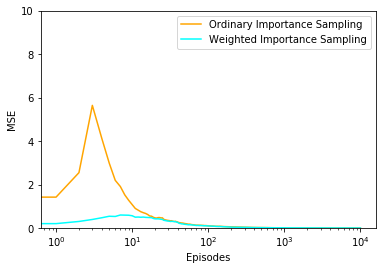

In [6]:
fig5_3()

In [30]:
# Generates random state
def select_random_init_state_and_action():
    action = np.random.randint(2)
    useable_ace = np.random.randint(2)
    player_sum = np.random.randint(12,22)
    dealer_card = np.random.randint(1,11)
    return ((player_sum,dealer_card,useable_ace),action)

# Monte Carlo First Visit Exploring starts Controls Problem
def fig5_2(): 
    game = BlackJack()
    
    """
    q[0,:,:,:] --> no usable ace
    q[1,:,:,:] --> usable ace
    q[:,x,:,:] --> dealer card 1 value
    q[:,:,y,:] --> player cards sum
    q[:,:,:,:0/1] --> stick / hit
    """
    q = np.zeros((2,10,10,2)) # Q values
    counts = np.zeros((2,10,10,2)) # Counts of occurance 
    policy = np.ones((2,10,10),dtype = "uint8")
    for i in range(4,7):
        policy[:,:,i] = actions["stick"]
                
    # Iterating over episodes
    for eps in tqdm(range(500000)):
        state_0,action = select_random_init_state_and_action() # Generate random state
        sequence, reward = game.play_episode(state_0,action,policy) # Generate episode
        for state, action in sequence:
            index = tuple(list(state)+[action])
            q[index] = (q[index]*counts[index] + reward)/(counts[index] + 1.) # Update Q value
            counts[index] += 1. # Update count
            #q[index] = q[index] + 0.2*(reward-q[index])
            policy[state] = np.argmax(q[state[0],state[1],state[2],:],0) # updating policy for given staten at each step
        policy = np.argmax(q,-1)
        
    v = np.amax(q, axis=3) # Generating state value function
        
        
    # plotting data
    
    fig = plt.figure(figsize=(12,6))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')
    
    ax1.set_title("No Usable Ace")
    ax2.set_title("Usable Ace")
    fig.suptitle("Optimal State Value Function")
    
    ################################################################################################################
    ##### Credit for plotting code --> https://stackoverflow.com/questions/11409690/plotting-a-2d-array-with-mplot3d
    
    x = np.array([[i] * 10 for i in range(10)]).ravel() # x coordinates of each bar
    y = np.array([i for i in range(10)] * 10) # y coordinates of each bar
    z = np.zeros(10*10) - 1 # z coordinates of each bar
    dx = np.ones(10*10) # length along x-axis of each bar
    dy = np.ones(10*10) # length along y-axis of each bar
    
    dz0 = v[0,:,:].ravel() + 1 # length along z-axis of each bar (height)
    dz1 = v[1,:,:].ravel() + 1 # length along z-axis of each bar (height)

    ax1.bar3d(x, y, z, dx, dy, dz0, color = "cyan")
    ax2.bar3d(x, y, z, dx, dy, dz1, color = "cyan")
    
    ################################################################################################################
        
    dealer_labels = ["","A",3,5,7,9]
    player_sum_labels = [12,14,16,18,20,22]
        
    fig2, ax3 = plt.subplots()
    ax3.set_ylim(0,9)
    ax3.set_xticklabels(dealer_labels)
    ax3.set_yticklabels(player_sum_labels)
   
    im = ax3.imshow(policy[0,:,:].T, cmap='cool_r', interpolation='nearest') # Creating heatmp
    fig2.colorbar(im, orientation='horizontal') 
    
    fig3, ax4 = plt.subplots()
    ax4.set_ylim(0,9)
    ax4.set_xticklabels(dealer_labels)
    ax4.set_yticklabels(player_sum_labels)
    
    im = ax4.imshow(policy[1,:,:].T, cmap='cool_r', interpolation='nearest') # Creating heatmp
    fig3.colorbar(im, orientation='horizontal')
    
    subplots = [ax1,ax2,ax3,ax4]
    for subplot in subplots:
        subplot.set_xlabel('Dealer Showing')
        subplot.set_ylabel('Player Sum')
    
    
    fig2.suptitle("Policy - No Usable Ace")
    fig3.suptitle("Policy - Usable Ace")
    
    fig.savefig("Fig5_2-ValueEstimates.png",dpi=300)
    fig2.savefig("Fig5_2-Policy-No_Ace.png",dpi=1200)
    fig3.savefig("Fig5_2-Policy-Ace.png",dpi=1200)
  
    plt.show()
        
    
    

100%|████████████████████████████████████████████████████████████████████████| 500000/500000 [01:13<00:00, 6838.02it/s]


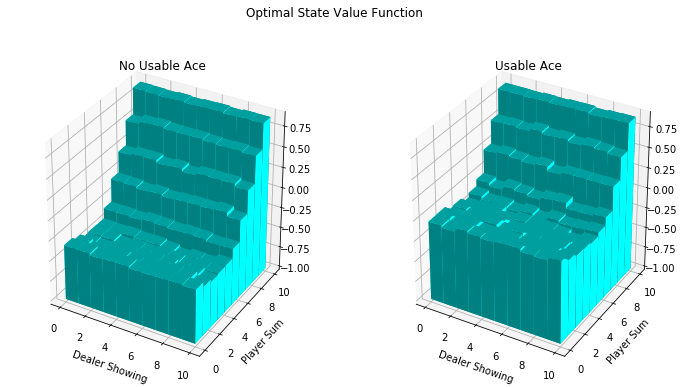

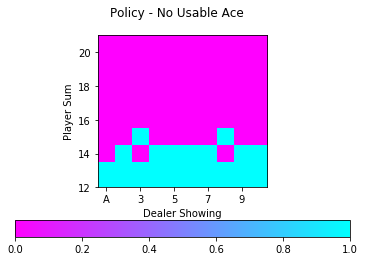

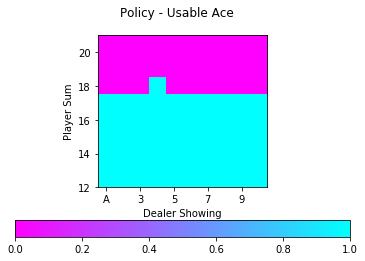

In [31]:
fig5_2()

In [135]:
def fig5_1(): # Monte Carlo First Visit Prediction Problem
    game = BlackJack()
    
    """
    v[0,:,:] --> no usable ace
    v[1,:,:] --> usable ace
    v[:,x,:] --> dealer card 1 value
    v[:,:,y] --> player cards sum
    """
    v = np.zeros((2,10,10))
    counts = np.zeros((2,10,10))
    
    # iterating over episodes - first 10000
    for eps in tqdm(range(10000)):
        sequence, reward = game.play_episode()
        for state, _ in sequence:
            v[state] = (v[state]*counts[state] + reward)/(counts[state] + 1.) # Updating state value function
            counts[state] += 1. # Updating count
    
    fig = plt.figure(figsize=(18,12))
    ax1 = fig.add_subplot(221, projection='3d')
    ax2 = fig.add_subplot(222, projection='3d')
    ax3 = fig.add_subplot(223, projection='3d')
    ax4 = fig.add_subplot(224, projection='3d')
    subplots = [ax1,ax2,ax3,ax4]
    
    ################################################################################################################
    ##### Credit for plotting code --> https://stackoverflow.com/questions/11409690/plotting-a-2d-array-with-mplot3d
    
    x = np.array([[i] * 10 for i in range(10)]).ravel() # x coordinates of each bar
    y = np.array([i for i in range(10)] * 10) # y coordinates of each bar
    z = np.zeros(10*10) - 1 # z coordinates of each bar
    dx = np.ones(10*10) # length along x-axis of each bar
    dy = np.ones(10*10) # length along y-axis of each bar
    
    dz0 = v[0,:,:].ravel() + 1 # length along z-axis of each bar (height)
    dz1 = v[1,:,:].ravel() + 1 # length along z-axis of each bar (height)

    ax1.bar3d(x, y, z, dx, dy, dz0, color = "cyan")
    ax2.bar3d(x, y, z, dx, dy, dz1, color = "cyan")
    
    ################################################################################################################
    
    # iterating over episodes - first 490000
    for eps in tqdm(range(490000)):
        sequence, reward = game.play_episode()
        for state, _ in sequence:
            v[state] = (v[state]*counts[state] + reward)/(counts[state] + 1.)
            counts[state] += 1.
    
    # Plotting data
    
    dz0 = v[0,:,:].ravel() + 1 # length along z-axis of each bar (height)
    dz1 = v[1,:,:].ravel() + 1 # length along z-axis of each bar (height)

    ax3.bar3d(x, y, z, dx, dy, dz0, color = "cyan")
    ax4.bar3d(x, y, z, dx, dy, dz1, color = "cyan")
    
    dealer_labels = ["A",3,5,7,9]
    player_sum_labels = [12,14,16,18,20,22]
    headers = ["After 10000 episodes (No Usable ace)","After 10000 episodes (Usable ace)",
               "After 500000 episodes (No Usable ace)","After 500000 episodes (Usable ace)"]
    
    for subplot,heading in zip(subplots,headers):
        subplot.set_xticklabels(dealer_labels)
        subplot.set_yticklabels(player_sum_labels)
        subplot.set_xlabel('Dealer Showing')
        subplot.set_ylabel('Player Sum')
        subplot.set_title(heading)

        
    fig.suptitle('Approximate State Value function values')
    
    plt.savefig('Fig5_1-MC-FV.png',dpi=1200)
    plt.show()

    

100%|███████████████████████████████████████████████████████████████████████| 490000/490000 [00:16<00:00, 30017.74it/s]


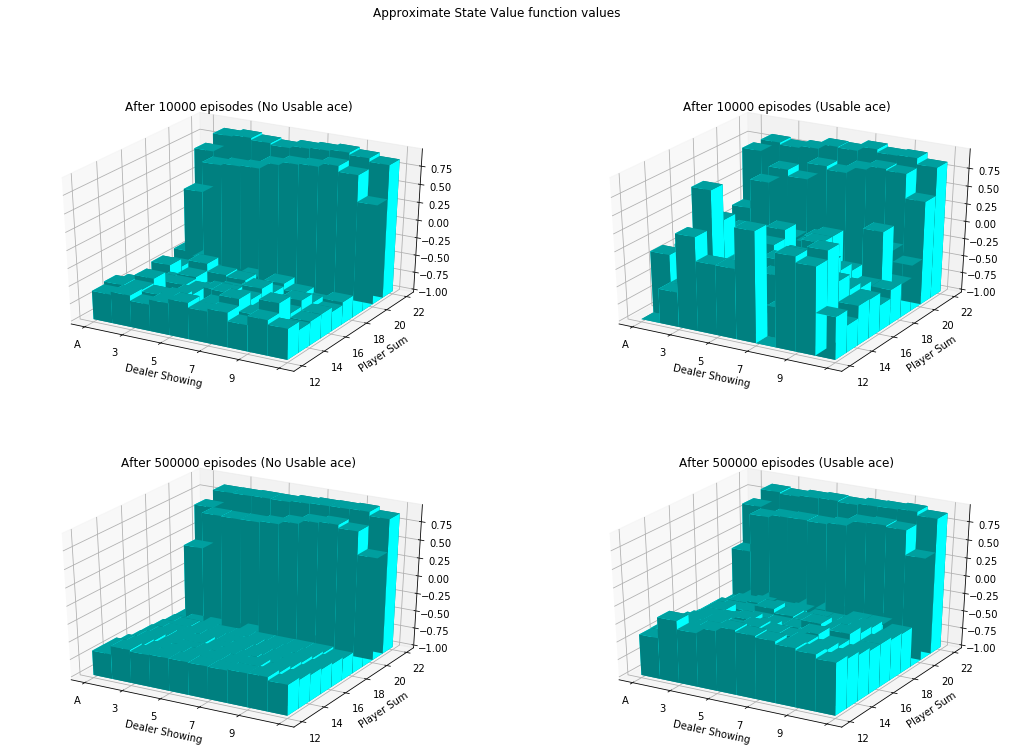

In [136]:
fig5_1()